<center><h1>Law Keywords Predictor</h1></center>

<h2>Loading Modules</h2>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import scipy.optimize as opt
from sklearn import metrics 
from sklearn.metrics import f1_score, jaccard_similarity_score, classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(0)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

Using TensorFlow backend.
C:\Users\smile\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\smile\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\smile\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\smile\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

<h2>Loading Data</h2>

In [ ]:
lst1=[]
lst2=[]
for i in range(80):
    name1="C:\\Users\\Aayush Singhal\\Downloads\\Projects\\8. Law Keywords Prediction\\Dataset\\Data\\Train_tags\\case"+str(i)+".txt"
    name2="C:\\Users\\Aayush Singhal\\Downloads\\Projects\\8. Law Keywords Prediction\\Dataset\\Data\\Train_docs\\case_"+str(i)+"_statement.txt"
    f1=open(name1,"r")
    f2=open(name2,"r")
    y=f1.read()
    for x in f2:
        x=x.replace("\n",'')
        if len(x)>0:
            lst2.append(x.replace('\n',''))
            lst1.append(y)
f1.close()
f2.close()
text=pd.DataFrame(data={"File":lst2,"Keywords":lst1})
text.head(10)

,File,Keywords
0,"Kurian Joseph, J.",Cause of Action
1,1. Leave granted in Special Leave Petition (Ci...,Cause of Action
2,2. Around 46.93 acres of Land was acquired by ...,Cause of Action
3,3. Learned Counsel for the Appellants submitte...,Cause of Action
4,"4. Shri Sanjay Kumar Tyagi, learned Additional...",Cause of Action
5,5. Learned Counsel appearing for the Appellant...,Cause of Action
6,"6. Prior to amendment Act 68 of 1984, the amou...",Cause of Action
7,Section 25. Rules as to amount of compensation-,Cause of Action
8,(1) When the applicant has made a claim to com...,Cause of Action
9,(2) When the applicant has refused to make suc...,Cause of Action


In [ ]:
text.dtypes

File        object
Keywords    object
dtype: object

In [ ]:
text.describe()

,File,Keywords
count,3961,3961
unique,3855,79
top,1. Leave granted.,"Absence, Accommodation, Amendment, Appeal, App..."
freq,17,313


<h2>Preprocessing Data</h2>

In [ ]:
print("Rows: {}\nColumns: {}".format(text.shape[0],text.shape[1]))

Rows: 3961
Columns: 2


In [ ]:
text.isnull().sum()

File        0
Keywords    0
dtype: int64

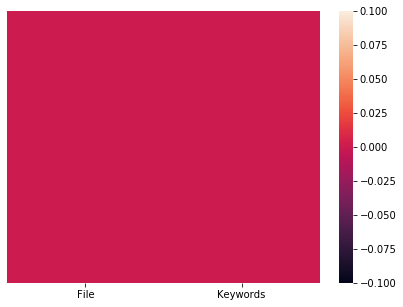

In [ ]:
plt.rcParams['figure.figsize']=7,5
sns.heatmap(text.isnull(),yticklabels=False)
plt.show()

<p>The dataset has no null values.</p>

<h3>Encoding labels into numbers</h3>

In [ ]:
Keyword_codes=text.groupby(['Keywords']).ngroup()
Keywords=text['Keywords'].unique()

In [ ]:
IDs=dict()
for i,j in zip(Keywords,Keyword_codes.unique()):
    IDs.update({j:i})

<h2>1. Using Machine Learning</h2>

<h3>Lemmatizing and Cleaning Sentences</h3>

In [ ]:
def word_clean(cases):
    processedText=[]
    wordLemm=WordNetLemmatizer()
    urlPattern=r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern='@[^\s]+'
    alphaPattern="[^a-zA-Z0-9]"
    sequencePattern=r"(.)\1\1+"
    seqReplacePattern=r"\1\1"   
    for case in cases:
        case=case.lower()
        case=re.sub(urlPattern,' URL',case)
        case=re.sub(userPattern,' USER',case)        
        case=re.sub(alphaPattern, " ",case)
        case=re.sub(sequencePattern, seqReplacePattern,case)
        casewords = ''
        for word in case.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                casewords += (word+' ')            
        processedText.append(casewords)
    return processedText
processedText=word_clean(text['File'])

In [ ]:
df=pd.DataFrame(data={"File":processedText,"Labels":Keyword_codes})
df.head()

,File,Labels
0,kurian joseph,67
1,leave granted in special leave petition civil ...,67
2,around 46 93 acre of land wa acquired by the r...,67
3,learned counsel for the appellant submitted th...,67
4,shri sanjay kumar tyagi learned additional adv...,67


In [ ]:
df.dtypes

File      object
Labels     int64
dtype: object

In [ ]:
df['Labels'].unique()

array([67,  2, 77, 68, 24, 41, 70, 15, 22, 34, 13, 14, 75, 76, 55, 40, 30,
        4, 10, 74, 56, 51, 69, 32,  3, 33, 78, 31, 23, 73, 43, 20, 19,  1,
       62,  0, 16, 57, 65, 47, 44, 59, 46, 26, 21, 36, 11, 25, 35, 64, 63,
       52, 42, 38, 28,  6, 60, 54, 12, 18, 29, 45, 61, 39, 17, 71, 49, 72,
        7, 53, 48, 27, 66,  8, 37,  9, 58, 50,  5], dtype=int64)

In [ ]:
len(df['Labels'].unique())

79

<h3>Converting to vectors</h3>

In [ ]:
vectoriser=TfidfVectorizer(ngram_range=(1,2),max_features=500000)
vectoriser.fit(df['File'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
X=vectoriser.transform(df['File'])

In [ ]:
def model_Evaluate(model):
    y_pred=model.predict(X)
    print(classification_report(df['Labels'],y_pred))
    cf_matrix=confusion_matrix(df['Labels'],y_pred)
    print(cf_matrix)
    return y_pred

<h2>Data Modelling</h2>

<h3>1. Bernoulli Naive Bayes</h3>

In [ ]:
BNBmodel=BernoulliNB(alpha=0.01)
BNBmodel.fit(X,df['Labels'])
Y1=model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        38
           1       0.97      0.91      0.94        92
           2       1.00      0.69      0.82        13
           3       0.93      0.94      0.94       100
           4       0.92      0.98      0.95        48
           5       1.00      0.85      0.92        33
           6       1.00      0.82      0.90       313
           7       1.00      0.95      0.98        66
           8       1.00      0.82      0.90        11
           9       0.46      0.98      0.63       153
          10       0.97      0.83      0.90        42
          11       1.00      0.79      0.88        29
          12       0.78      0.95      0.86        65
          13       1.00      0.90      0.95        40
          14       1.00      0.82      0.90        68
          15       1.00      0.80      0.89        45
          16       1.00      0.87      0.93        23
          17       1.00    

<h3>Accuracy Metrics</h3>

In [ ]:
J1=jaccard_similarity_score(df['Labels'],Y1)
FS1=f1_score(df['Labels'],Y1,average='weighted')
Acc1=metrics.accuracy_score(df['Labels'],Y1)*100

C:\Users\smile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


<h3>2. Support Vector Machine</h3>

In [ ]:
SVCmodel=LinearSVC()
SVCmodel.fit(X,df['Labels'])
Y2=model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        38
           1       0.97      0.98      0.97        92
           2       1.00      1.00      1.00        13
           3       1.00      0.98      0.99       100
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        33
           6       1.00      0.99      0.99       313
           7       1.00      0.97      0.98        66
           8       1.00      0.91      0.95        11
           9       1.00      0.97      0.99       153
          10       1.00      0.88      0.94        42
          11       1.00      0.97      0.98        29
          12       0.98      0.97      0.98        65
          13       1.00      0.93      0.96        40
          14       0.96      1.00      0.98        68
          15       1.00      0.93      0.97        45
          16       1.00      0.96      0.98        23
          17       0.99    

<h3>Accuracy Metrics</h3>

In [ ]:
J2=jaccard_similarity_score(df['Labels'],Y2)
FS2=f1_score(df['Labels'],Y2,average='weighted')
Acc2=metrics.accuracy_score(df['Labels'],Y2)*100

C:\Users\smile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


<h3>3. Passive Aggressive Classifier</h3>

In [ ]:
PAC=PassiveAggressiveClassifier()
PAC.fit(X,df['Labels'])
Y3=model_Evaluate(PAC)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.97      0.98      0.97        92
           2       1.00      1.00      1.00        13
           3       1.00      0.98      0.99       100
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        33
           6       1.00      0.99      0.99       313
           7       0.76      1.00      0.86        66
           8       1.00      0.91      0.95        11
           9       1.00      0.97      0.99       153
          10       1.00      0.88      0.94        42
          11       1.00      0.97      0.98        29
          12       0.98      0.97      0.98        65
          13       0.95      0.95      0.95        40
          14       1.00      0.97      0.99        68
          15       0.96      0.96      0.96        45
          16       1.00      0.96      0.98        23
          17       0.99    

<h3>Accuracy Metrics</h3>

In [ ]:
J3=jaccard_similarity_score(df['Labels'],Y3)
FS3=f1_score(df['Labels'],Y3,average='weighted')
Acc3=metrics.accuracy_score(df['Labels'],Y3)*100

<h3>4. K-Nearest Neighbors</h3>

<h4>Selecting best K value</h4> 

In [ ]:
Ks=20
mean_acc1=np.zeros((Ks-1))
std_acc1=np.zeros((Ks-1))
for n in range(1,Ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X,df['Labels'])
    Y4=neigh.predict(X)
    mean_acc1[n-1]=metrics.accuracy_score(df['Labels'],Y4)
    std_acc1[n-1]=np.std(Y4==df['Labels'])/np.sqrt(Y4.shape[0])
print(mean_acc1)
print(std_acc1)

[0.96667508 0.38677102 0.14440798 0.2557435  0.20600858 0.17520828
 0.15829336 0.14617521 0.1350669  0.12320121 0.11941429 0.11285029
 0.1075486  0.10376168 0.09921737 0.09845998 0.09745014 0.09492552
 0.09568291]
[0.00285182 0.00773813 0.00558504 0.00693204 0.00642611 0.00604014
 0.00579975 0.00561331 0.00543079 0.00522222 0.00515242 0.00502745
 0.00492257 0.00484538 0.00475009 0.00473391 0.00471221 0.00465727
 0.00467385]


In [ ]:
neigh=KNeighborsClassifier(n_neighbors=1).fit(X,df['Labels'])
Y4=model_Evaluate(neigh)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        38
           1       1.00      0.97      0.98        92
           2       1.00      1.00      1.00        13
           3       0.95      0.99      0.97       100
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        33
           6       0.99      0.99      0.99       313
           7       1.00      0.97      0.98        66
           8       1.00      0.91      0.95        11
           9       1.00      0.97      0.99       153
          10       0.95      0.98      0.96        42
          11       1.00      0.97      0.98        29
          12       1.00      0.95      0.98        65
          13       0.95      0.95      0.95        40
          14       0.99      0.99      0.99        68
          15       0.54      1.00      0.70        45
          16       0.92      1.00      0.96        23
          17       1.00    

<h3>Accuracy Metrics</h3>

In [ ]:
J4=jaccard_similarity_score(df['Labels'],Y4)
FS4=f1_score(df['Labels'],Y4,average='weighted')
Acc4=metrics.accuracy_score(df['Labels'],Y4)*100

C:\Users\smile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


<h3>5. Multinomial Naive Bayes</h3> 

In [ ]:
MNB=MultinomialNB(alpha=0.01)
MNB.fit(X,df['Labels'])
Y5=model_Evaluate(MNB)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        38
           1       1.00      0.97      0.98        92
           2       1.00      1.00      1.00        13
           3       1.00      0.97      0.98       100
           4       1.00      1.00      1.00        48
           5       1.00      0.97      0.98        33
           6       0.86      1.00      0.92       313
           7       1.00      0.97      0.98        66
           8       1.00      0.91      0.95        11
           9       0.99      0.97      0.98       153
          10       1.00      0.88      0.94        42
          11       1.00      0.97      0.98        29
          12       0.98      0.97      0.98        65
          13       1.00      0.90      0.95        40
          14       1.00      0.97      0.99        68
          15       1.00      0.93      0.97        45
          16       1.00      0.96      0.98        23
          17       0.99    

<h3>Accuracy Metrics</h3>

In [ ]:
J5=jaccard_similarity_score(df['Labels'],Y5)
FS5=f1_score(df['Labels'],Y5,average='weighted')
Acc5=metrics.accuracy_score(df['Labels'],Y5)*100

C:\Users\smile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


<h3>6. Decision Tree</h3>

<h4>Selecting best depth</h4>

In [ ]:
k=50
mean_acc3=np.zeros((k-1))
std_acc3=np.zeros((k-1))
for n in range(1,k):
    Tree=DecisionTreeClassifier(criterion='entropy',max_depth=n)
    Tree.fit(X,df['Labels'])
    Y=Tree.predict(X)
    mean_acc3[n-1]=metrics.accuracy_score(df['Labels'],Y)
    std_acc3[n-1]=np.std(Y==df['Labels'])/np.sqrt(Y.shape[0])
print(mean_acc3)
print(std_acc3)

[0.08861399 0.11966675 0.13632921 0.16233274 0.17924766 0.21282504
 0.24943196 0.28225196 0.32668518 0.36758394 0.41858117 0.46276193
 0.51224438 0.55894976 0.60716991 0.65160313 0.6904822  0.73794496
 0.78187326 0.82479172 0.86038879 0.88714971 0.90103509 0.91062863
 0.91769755 0.9232517  0.92729109 0.92830093 0.92905832 0.93057309
 0.93133047 0.93158293 0.93284524 0.93461247 0.93562232 0.93688463
 0.93738955 0.93814693 0.93839939 0.93865186 0.93890432 0.9396617
 0.93991416 0.94041909 0.94142893 0.94243878 0.94319616 0.94344862
 0.94395355]
[0.00451544 0.00515713 0.00545213 0.00585917 0.00609439 0.00650346
 0.00687494 0.00715158 0.00745197 0.00766086 0.00783848 0.00792245
 0.00794214 0.00788911 0.00775988 0.00757053 0.00734542 0.00698724
 0.00656176 0.00604014 0.00550687 0.00502745 0.0047447  0.00453281
 0.0043667  0.00422953 0.00412572 0.0040992  0.00407915 0.00403865
 0.0040182  0.00401135 0.00397686 0.0039279  0.00389956 0.00386374
 0.00384929 0.00382749 0.00382018 0.00381286 0.003

In [ ]:
Tree=DecisionTreeClassifier(criterion='entropy',max_depth=50)
Tree.fit(X,df['Labels'])
Y6=model_Evaluate(Tree)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        38
           1       0.97      0.92      0.94        92
           2       1.00      0.92      0.96        13
           3       0.95      0.97      0.96       100
           4       1.00      0.98      0.99        48
           5       1.00      0.97      0.98        33
           6       1.00      0.97      0.99       313
           7       1.00      0.97      0.98        66
           8       0.85      1.00      0.92        11
           9       1.00      0.97      0.99       153
          10       0.95      0.98      0.96        42
          11       1.00      0.93      0.96        29
          12       0.98      0.97      0.98        65
          13       0.95      0.95      0.95        40
          14       1.00      0.94      0.97        68
          15       1.00      0.89      0.94        45
          16       1.00      0.96      0.98        23
          17       0.99    

<h3>Accuracy Metrics</h3>

In [ ]:
J6=jaccard_similarity_score(df['Labels'],Y6)
FS6=f1_score(df['Labels'],Y6,average='weighted')
Acc6=metrics.accuracy_score(df['Labels'],Y6)*100

C:\Users\smile\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


<h2>Train-Set Performance</h2>

In [ ]:
per={'Model':['Bernoulli Naive Bayes','Support Vector Machine','Passive Aggressive Classifier','K-Nearest Neighbors',
     'Multinomial Naive Bayes','Decision Tree'],'Accuracy (%)':[round(Acc1,2),round(Acc2,2),round(Acc3,2),round(Acc4,2),
      round(Acc5,2),round(Acc6,2)],
     'Jaccard Index':[J1,J2,J3,J4,J5,J6],'F1-Score':[FS1,FS2,FS3,FS4,FS5,FS6]}
Per=pd.DataFrame(data=per)
Per.set_index('Model',inplace=True)
Per

,Accuracy (%),Jaccard Index,F1-Score
Model,,,
Bernoulli Naive Bayes,86.87,0.868720,0.878655
Support Vector Machine,96.72,0.967180,0.968658
Passive Aggressive Classifier,96.72,0.967180,0.967327
K-Nearest Neighbors,96.67,0.966675,0.968565
Multinomial Naive Bayes,96.06,0.960616,0.960877
Decision Tree,94.45,0.944458,0.948486


<p>Since the <b>SVM</b> model shows the best results, we choose it for predicting the keywords.</p>

<h2>Prediction</h2>

In [ ]:
lst3=[]
index=[]
for i in range(100,201):
    name3="C:\\Users\\Aayush Singhal\\Downloads\\Projects\\8. Law Keywords Prediction\\Dataset\\Data\\Test_docs\\case_"+str(i)+"_statement.txt"
    f3=open(name3,"r")
    for x in f3:
        x=x.replace("\n",'')
        if len(x)>0:
            lst3.append(x.replace('\n',''))
    index.append(len(lst3))
f3.close()
text1=pd.DataFrame(data={"File":lst3})
text1.head(10)

,File
0,"P. Venkatarama Reddi, J."
1,1. The opinion recorded by the Kerala High Cou...
2,"""Whether on the facts and in the circumstances..."
3,The High Court accepted the view of the Tribun...
4,2. The facts in brief are: The respondent-asse...
5,"3. On further appeal by the assessee, the Trib..."
6,4. It may be noted that the provision was made...
7,5. The learned senior counsel appearing for th...
8,6. The decision of this Court in Commissioner ...
9,"7. For the reasons aforesaid, we affirm the op..."


<h3>Lemmatizing and Cleaning Sentences</h3>

In [ ]:
new=word_clean(text1['File'])

In [ ]:
X1=vectoriser.transform(new)

In [ ]:
X1.shape

(4548, 108125)

In [ ]:
Y_hat=SVCmodel.predict(X1)
Y_hat

array([62, 27, 35, ..., 24, 21, 21], dtype=int64)

In [ ]:
Labels=[]
for i in Y_hat:
    Labels.append(IDs[i])
final={"File":new,"Keywords":Labels}
df_final=pd.DataFrame(data=final)
df_final.head(10)

,File,Keywords
0,venkatarama reddi,"Attesting Witness, Consideration, Investigatio..."
1,the opinion recorded by the kerala high court ...,"Acknowledgement, Assurance, Auction, Bill, Buy..."
2,whether on the fact and in the circumstance of...,"Adjudication, Administrative Power, Back Wage,..."
3,the high court accepted the view of the tribun...,"Acknowledgement, Assurance, Auction, Bill, Buy..."
4,the fact in brief are the respondent assessee ...,"Adjudication, Administrative Power, Back Wage,..."
5,on further appeal by the assessee the tribunal...,"Adjudication, Administrative Power, Back Wage,..."
6,it may be noted that the provision wa made in ...,"Adjudication, Administrative Power, Back Wage,..."
7,the learned senior counsel appearing for the i...,"Adjudication, Administrative Power, Back Wage,..."
8,the decision of this court in commissioner of ...,"Assault, Circumstantial Evidence, Corroboratio..."
9,for the reason aforesaid we affirm the opinion...,"Constitutional Validity, Defamation"


<h3>Prediction for a complete statement</h3>

<p>Here, we will see the maximum keywords predicted for the entire last statement,</p>

In [ ]:
df_final['File'][index[-2]:index[-1]]

4531    having heard learned counsel appearing for the...
4532    the secretary ministry of woman and child deve...
4533    the secretary ministry of woman and child deve...
4534    insofar a the website viz URL concerned it is ...
4535    it appears that many state have prepared their...
4536    the secretary ministry of woman and child deve...
4537    he will also take urgent step to fill up all t...
4538    the secretary ministry of woman and child deve...
4539    the affidavit filed by some of the state gover...
4540    the secretary ministry of woman and child deve...
4541    we request the director faculty of management ...
4542    we also find from the affidavit filed by the v...
4543    under the circumstance we request the director...
4544    the director of the faculty of management stud...
4545    the secretary ministry of woman and child deve...
4546    in compliance of this court order the chief se...
4547    liberty to the state of tripura and chhattisga...
Name: File, dt

In [ ]:
df_final['Keywords'][index[-2]:index[-1]].value_counts()

Account, Auditor, Authentication, Commercial, Consent, Direction, Dispute, Due, Generating Station, National Commission, Rate, Tariff                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

<h2>2. Using Deep Learning</h2>

In [ ]:
emojis={':)':'smile',':-)':'smile',';d':'wink',':-E':'vampire',':(':'sad',':-(':'sad',':-<':'sad',':P':'raspberry',':O':'surprised',
        ':-@':'shocked',':@':'shocked',':-$':'confused',':\\':'annoyed',':#':'mute',':X':'mute',':^)':'smile',':-&':'confused','$_$':'greedy',
        '@@':'eyeroll',':-!':'confused',':-D':'smile',':-0':'yell','O.o':'confused','<(-_-)>':'robot','d[-_-]b':'dj',":'-)":'sadsmile',';)':'wink', 
        ';-)':'wink','O:-)':'angel','O*-)':'angel','(:-D': 'gossip','=^.^=':'cat'}
stopwords=['a','about','above','after','again','ain','all','am','an','and','any','are','as','at','be','because','been','before',
           'being','below','between','both','by','can','d','did','do','does','doing','down','during','each','few','for','from', 
           'further','had','has','have','having','he','her','here','hers','herself','him','himself','his','how','i','if','in',
           'into','is','it','its','itself','just','ll','m','ma','me','more','most','my','myself','now','o','of','on','once',
           'only','or','other','our','ours','ourselves','out','own','re','s','same','she','shes','should','shouldve','so','some',
           'such','t','than','that',"thatll",'the','their','theirs','them','themselves','then','there','these','they','this',
           'those','through','to','too','under','until','up','ve','very','was','we','were','what','when','where','which','while',
           'who','whom','why','will','with','won','y','you','youd','youll','youre','youve','your','yours','yourself','yourselves']

In [ ]:
def preprocess(textdata):
    processedText=[]
    wordLemm=WordNetLemmatizer()
    urlPattern=r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern='@[^\s]+'
    alphaPattern="[^a-zA-Z0-9]"
    sequencePattern=r"(.)\1\1+"
    seqReplacePattern=r"\1\1"
    for tweet in textdata:
        tweet=tweet.lower()
        tweet=re.sub(urlPattern,' URL',tweet)
        for emoji in emojis.keys():
            tweet=tweet.replace(emoji,"EMOJI"+emojis[emoji])        
        tweet=re.sub(userPattern,' USER',tweet)        
        tweet=re.sub(alphaPattern," ",tweet)
        tweet=re.sub(sequencePattern,seqReplacePattern,tweet)
        tweetwords=''
        for word in tweet.split():
            if len(word)>1:
                word=wordLemm.lemmatize(word)
                tweetwords+=(word+' ')
        processedText.append(tweetwords)
    return processedText

In [ ]:
processedtext=preprocess(list(text['File']))

In [ ]:
index=[]
for x in range(len(processedtext)):
    processedtext[x]=processedtext[x].strip()
    if len(processedtext[x])==1:
        processedtext[x]=''
    if processedtext[x]=='':
        index.append(x)
text['processed']=processedtext
text_final=text[text['processed']!='']
text_final.reset_index(drop=True,inplace=True)

In [ ]:
maxLen=len(max(processedtext,key=len).split())

In [ ]:
def convert_to_one_hot(Y,C):
    Y=np.eye(C)[Y.values.reshape(-1)]
    return Y

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file,'r',encoding='UTF-8') as f:
        words=set()
        word_to_vec_map={}
        for line in f:
            line=line.strip().split()
            curr_word=line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word]=np.array(line[1:],dtype=np.float64)
        i=1
        words_to_index={}
        index_to_words={}
        for w in sorted(words):
            words_to_index[w]=i
            index_to_words[i]=w
            i=i+1
    return words_to_index,index_to_words,word_to_vec_map

In [ ]:
word_to_index,index_to_word,word_to_vec_map=read_glove_vecs('C:\\Users\\Aayush Singhal\\Documents\\Projects\\Trials\\glove.6B.50d.txt')

In [ ]:
def sentence_to_avg(sentence,word_to_vec_map):
    words=sentence.strip().split(" ")
    avg=np.zeros((50,))
    total=0
    zrs=np.zeros((50,))
    for w in words:
        try:
            total+=word_to_vec_map[w]
        except:
            total+=zrs
    avg=total/len(words)
    return avg

In [ ]:
text_final['Keyword_Codes']=Keyword_codes

C:\Users\smile\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train=text_final['processed']
y_train=text_final['Keyword_Codes']

In [ ]:
def sentences_to_indices(X,word_to_index,max_len):
    m=X.shape[0]
    X_indices=np.zeros((m,max_len))
    for i in range(m):
        sentence_words=X[i].lower().strip().split(" ")
        if '' in sentence_words:
            sentence_words.remove('')
        j=0
        for w in sentence_words:
            try:
                X_indices[i,j]=word_to_index[w]
            except:
                pass
            j=j+1
    return X_indices

In [ ]:
def pretrained_embedding_layer(word_to_vec_map,word_to_index):
    vocab_len=len(word_to_index)+1
    emb_dim=word_to_vec_map["cucumber"].shape[0]
    emb_matrix=np.zeros((vocab_len,emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx,:]=word_to_vec_map[word]
    embedding_layer=Embedding(input_dim=vocab_len,output_dim=emb_dim,trainable=True)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [ ]:
def SA_LSTM(input_shape,word_to_vec_map,word_to_index):
    sentence_indices=Input(shape=input_shape,dtype='int32')
    embedding_layer=pretrained_embedding_layer(word_to_vec_map,word_to_index)
    embeddings=embedding_layer(sentence_indices)   
    X=LSTM(units=128,return_sequences=True)(embeddings)
    X=Dropout(rate=0.3)(X)
    X=LSTM(units=128)(X)
    X=Dropout(rate=0.3)(X)
    X=Dense(units=80)(X)
    X=Activation('softmax')(X)
    model=Model(inputs=sentence_indices,outputs=X)
    return model

In [ ]:
model=SA_LSTM((maxLen,),word_to_vec_map,word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4658)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 4658, 50)          20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 4658, 128)         91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4658, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                1032

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
X_train_indices=sentences_to_indices(X_train,word_to_index,maxLen)
Y_train_oh=convert_to_one_hot(y_train,C=80)

In [ ]:
model.fit(X_train_indices,Y_train_oh,epochs=25,batch_size=32,shuffle=True)

Epoch 1/25
  64/3922 [..............................] - ETA: 1:55:45 - loss: 4.3374 - accuracy: 0.031 - ETA: 1:56:30 - loss: 4.3155 - accuracy: 0.0469

KeyboardInterrupt: 

In [ ]:
X_test_indices=sentences_to_indices(X_test,word_to_index,max_len=maxLen)
Y_test_oh=convert_to_one_hot(Y_test,C=3)
loss,acc=model.evaluate(X_test_indices,Y_test_oh)
print("Test accuracy= ",acc)

In [ ]:
X_test=np.array(['not feeling happy'])
X_test_indices=sentences_to_indices(X_test,word_to_index,maxLen)
print(X_test[0]+' '+np.argmax(model.predict(X_test_indices)))

<h1>Deep Learning Classification</h1> 

In [ ]:
X_train_indices=sentences_to_indices(X_train,word_to_index,maxLen)
X_train_indices.shape

(3922, 4658)

In [ ]:
Y_train_oh=convert_to_one_hot(y_train,C=79)
Y_train_oh.shape

(3922, 79)

In [ ]:
model=Sequential()
n_cols=X_train_indices.shape[1]
target=Y_train_oh
model.add(Dense(100,activation='relu',input_shape=(n_cols,)))
model.add(Dense(100,activation='tanh'))
model.add(Dense(100,activation='tanh'))
model.add(Dense(79,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train_indices,target,epochs=100)

Epoch 1/100
3922/3922 [==============================] - 3s 686us/step - loss: 4.0782 - accuracy: 0.0829
Epoch 2/100
3922/3922 [==============================] - 2s 606us/step - loss: 3.9432 - accuracy: 0.0946
Epoch 3/100
3922/3922 [==============================] - 2s 628us/step - loss: 3.9041 - accuracy: 0.09661s - loss: 3.8 - ETA: 0s - loss: 3.8885 - 
Epoch 4/100
3922/3922 [==============================] - 2s 626us/step - loss: 3.8881 - accuracy: 0.09870s - loss: 3.8890 - accuracy: 0.09
Epoch 5/100
3922/3922 [==============================] - 3s 724us/step - loss: 3.8929 - accuracy: 0.1005
Epoch 6/100
3922/3922 [==============================] - 2s 634us/step - loss: 3.8698 - accuracy: 0.10021s - los - ETA: 0s - los
Epoch 7/100
3922/3922 [==============================] - 2s 633us/step - loss: 3.8648 - accuracy: 0.09990s - loss: 3.8725 
Epoch 8/100
3922/3922 [==============================] - 3s 638us/step - loss: 3.8609 - accuracy: 0.1020
Epoch 9/100
3922/3922 [===================